In [26]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [27]:
corr = data.corr()
corr["DEATH_EVENT"].sort_values(ascending = False) #Checking the features which give the most information

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64

### Checking how the datapoints are laid out on the graph

Text(0, 0.5, 'Age')

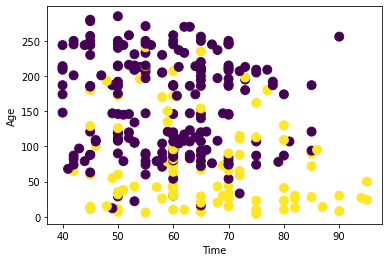

In [28]:
fig = plt.figure()
x = data.drop("DEATH_EVENT", axis = 1)
y = data["DEATH_EVENT"]
plt.scatter(x.iloc[:,0],x.iloc[:,11], c = y, s = 80) #accessing the 0th (age) and 11th(time) column 
plt.xlabel("Time")
plt.ylabel("Age")



# Kernel Support Vector Machine

In [29]:
import numpy as np

"""
Support Vector Machine Class which can 
    handle multiclass problems as well as implement linear kernel

"""
class SVM:
    def __init__(self, learning_rate=0.01, lambda_par=0.1, epoch=100,kernel = 0):
        self.learning_rate = learning_rate # This is set to control the steps taken to minimise the coef
        self.lambda_par = lambda_par # Regularisation parameter
        self.epoch = epoch # No of times the algorithm is run through each data set
        self.kernel = kernel
        
    
    def fit(self, X, y):
        number_samples, number_features = X.shape
        self.X = X
        self.classes = np.unique(y) # Gets us the number of classes in the dataset 
        number_classes = len(self.classes)

        
        self.classes_weights = []   # Will be used to stored the weights from each class
        
        
        for n in range(number_classes):
            label = np.where(y != self.classes[n],-1,1) # Setting all the classes that do not have the same label as current class to -1 and the current class as 1
            w, b = self.class_fit(X, label)
            self.classes_weights.append((w, b))

        
    def gradient_descent(self, X, Y, w, b, lambda_par, sign):  # Update rule to find the optimal weight and bias by minimzing the hinge loss
        if sign: 
            dw = 2*lambda_par*w
            db = 0
            w = w + (-self.learning_rate*dw)  # '-self.learning_rate' if the gradient is postive, the new values will go downwards
            b = b + (-self.learning_rate*db)
            return w, b
        else:                                             # Optimising the weights if the predicted label is not correct
            dw = 2*lambda_par*w-(np.dot(Y,X))
            db = Y
            w = w + (-self.learning_rate*dw) # '-self.learning_rate' if the gradient is negative, the new values will go upwards
            b = b + (-self.learning_rate*db)
        
        return w, b



    def predict(self, X):#Predict function uses the weights which return the best score and classifies accordingly
        x = X
        if self.kernel ==1:
            
            try:
                X_temp = np.dot(np.linalg.inv(self.x), self.X) # Transforming the data so that it matches with the training sample dimensions
            except:
                X_temp = np.dot(np.linalg.inv(self.x + 0.0001*np.identity(self.x.shape[0])), self.X) #if the try doesn't work because there is a correlation between 2 series
                                                                                                           #then noise is added to prevent the singular matrix error
            else:
                X_temp = np.dot(np.linalg.inv(self.x), self.X)

            x = self.apply_linear_kernel(X,X_temp) # Applying kernel function to the test sample 
            
        confidence_score = np.zeros((len(x), len(self.classes)))
        for i in range(len(self.classes_weights)):            # Loop goes through all the weights calculated earlier, to see which combination gives the best score
            weight, bias = self.classes_weights[i]
            confidence_score[:, i] = np.dot(x, weight) + bias    # Applying the optimised weight to the new features / test sample, result stored in numpy confidence_score
        return self.classes[np.argmax(confidence_score, axis=1)] # Returns the class with the highest confidence score
   
    
    #Linear Kernel function
    def apply_linear_kernel(self,X,x):
        return np.dot(X, x.T)

    
    # Function carries out checks before performing gradient descent. Finds the optimal weights for the data
    def class_fit(self, X, label):
        self.x = X
        b = 0
        w = np.zeros(self.x.shape[1])
        if self.kernel==1:
            self.x = self.apply_linear_kernel(X,X) # applying kernel to the training set
            w = np.zeros(self.x.shape[1]) # weight adjusted accordingly if kernel is applied
        for i in range(0,self.epoch):      
            for indx, feature in enumerate(self.x):     
                constraint = label[indx] * (np.dot(w, feature) - b) > 1    
                if constraint:
                    w,b = self.gradient_descent(feature,label[indx],w,b,self.lambda_par,True)
                else:
                    w,b = self.gradient_descent(feature,label[indx],w,b,self.lambda_par,False)
        return w,b
    
    
    def accuracy(self, y_true, y_pred):
       #Calculates the accuracy by dividing the correct labels by the total number of labels in test sample
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy



# Cross Validation function

In [30]:
"""
Cross Validation function 
Splits the data into the required folds and returns the accuracy result of each fold

"""

def cross_validation(predictor, x, y, folds=10):
    number_samples = len(y)
    fold_size = int(number_samples / folds) #int is used so we dont get float values, rounds the number down if float
    accuracy_scores = []
    for i in range(0,folds):
        # split data into train and test
        start = i * fold_size      # Each iteration will change the start and end point to make the new folds.                The next iteration the start will be where the previous ended
        end = start + fold_size    
        x_test = x[start:end]      # Making a test samples of for each fold
        y_test = y[start:end] 
        
        x_train_data = np.concatenate((x[:start], x[end:]), axis=0)  # Joining the rest of the data together,                which isn't in the test samples to make training sets
        x_train = x_train_data
        y_train_data = np.concatenate((y[:start], y[end:]), axis=0)
        y_train=y_train_data
        
        
        predictor.fit(x_train, y_train)       # Using the predictor algorithm to make predictions                        and then store the prediction scores in the accuracy array
        y_pred = predictor.predict(x_test)
        acc = predictor.accuracy(y_test,y_pred)
        accuracy_scores.append(acc)
    return np.array(accuracy_scores)








# Accessing Health Failure Clinical Recrods Dataset

In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Getting the data
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 27)
y_train_data = train_set["DEATH_EVENT"] #Getting the labels for training set
x_train_data = train_set.drop(["DEATH_EVENT"], axis=1) #Getting the features for training set 
y_test_data = test_set['DEATH_EVENT']
x_test_data = test_set.drop(["DEATH_EVENT"], axis=1)
    
y_train =  y_train_data.values
x_train =  x_train_data.values
y_test =  y_test_data.values
x_test =  x_test_data.values

## Testing standard svm on the first dataset: 
#### Parameters can be changed to see how the accuracy score is affected


In [33]:
clf = SVM(learning_rate = 0.01, lambda_par = 0.1, epoch = 100)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("SVM classification accuracy", clf.accuracy(y_test, predictions))

SVM classification accuracy 0.3333333333333333


## Testing the SVM with the kernel function on the first dataset: 
#### Parameters can be changed to see how the accuracy score is affected


In [34]:
clf = SVM(learning_rate = 0.01, lambda_par = 0.01, epoch = 100, kernel = 1)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("SVM classification accuracy", clf.accuracy(y_test, predictions))

SVM classification accuracy 0.6666666666666666


## Testing the standrad SVM with cross validation: 
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [35]:
y = data["DEATH_EVENT"]
x = data.drop("DEATH_EVENT", axis=1)
y_labels = y.values
x_features = x.values

svm = SVM(learning_rate=0.01, lambda_par=0.1, epoch=100,kernel = 0)
scores = cross_validation(svm, x_features, y_labels, folds = 10)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.10344828 0.17241379 0.48275862 0.86206897 0.82758621 0.79310345
 0.68965517 0.86206897 0.96551724 0.93103448]
Mean accuracy: 0.6689655172413793


## Cross validation with kernel: 
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [36]:
y = data["DEATH_EVENT"]
x = data.drop("DEATH_EVENT", axis=1)
y_labels = y.values
x_features = x.values

svmk = SVM(learning_rate = 0.01, lambda_par = 0.1, epoch = 100, kernel = 1)
scores = cross_validation(svmk, x_features, y_labels, folds = 10)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.10344828 0.82758621 0.51724138 0.13793103 0.17241379 0.20689655
 0.31034483 0.13793103 0.96551724 0.06896552]
Mean accuracy: 0.3448275862068966


# 

# Below cells perform the calculations on the FETAL HEALTH dataset

# Dataset 2: Fetal Health

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

data2 = pd.read_csv('fetal_health.csv')
train_set, test_set = train_test_split(data2, test_size = 0.2, random_state = 27)
y_train_data = train_set["fetal_health"] # Getting the labels for training set which is stored under DEATH_EVENT
x_train_data = train_set.drop("fetal_health", axis=1) #Getting the features for training set by removing the label column

# Extracting the features and labels for the test samples
y_test_data = test_set['fetal_health']
x_test_data = test_set.drop("fetal_health", axis=1)
  
# Extracting the values from the dataset    
y_train =  y_train_data.values
x_train =  x_train_data.values
y_test =  y_test_data.values
x_test =  x_test_data.values

In [49]:
data2.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [50]:
data2.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [51]:
data2.isnull()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2122,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2123,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2124,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Testing standard svm on the second dataset: 
#### Parameters can be changed to see how the accuracy score is affected


In [52]:
clf = SVM(learning_rate = 0.1, lambda_par = 0.001, epoch = 1000)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(predictions)
print("SVM classification accuracy", clf.accuracy(y_test, predictions))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 1. 2. 1. 1. 1. 1. 2. 1. 3. 1. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 2. 3. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 3. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 3. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 3. 1. 1. 1. 1. 1.

## Testing the kernel SVM on the second dataset
#### Parameters can be changed to see how the accuracy score is affected


In [45]:
clf = SVM(learning_rate = 0.01, lambda_par = 0.1, epoch = 100, kernel = 1)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("SVM classification accuracy", clf.accuracy(y_test, predictions))

SVM classification accuracy 0.7699530516431925


## Cross Validation testing with the standard SVM:
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [54]:
y = data2["fetal_health"]
x = data2.drop("fetal_health", axis=1)
y_labels = y.values
x_features = x.values



svm =  SVM(learning_rate = 0.1, lambda_par = 0.001, epoch = 1000)
scores = cross_validation(svm, x_features, y_labels,folds = 5)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores)) 

Cross validation scores: [0.62588235 0.67764706 0.97882353 0.88235294 0.83529412]
Mean accuracy: 0.8


## Cross Validation testing with the kernel SVM: 
#### Parameters can be adjusted to test different parameters of the algorithm with cross validation or test with different number of folds

In [47]:
y = data2["fetal_health"]
x = data2.drop("fetal_health", axis=1)
y_labels = y.values
x_features = x.values

svmK = SVM(learning_rate = 0.01, lambda_par = 0.1, epoch = 100, kernel = 1) 
scores = cross_validation(svmK, x_features, y_labels, folds = 5)
print("Cross validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross validation scores: [0.58352941 0.65882353 0.32705882 0.88235294 0.79764706]
Mean accuracy: 0.6498823529411764
